In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from scipy import linalg

In [12]:
#Set parameters
Lx = 0.01
Ly = 0.01
nx = 21
ny = 21
dx = Lx / (nx-1)
dy = Ly / (ny-1)
alpha = 1e-4

#Save memory space icin 2D array kullanmadim
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

#Initial conditions
T0 = 20.0 * numpy.ones((ny, nx))
T0[0, :] = 100.0 # bottom
T0[:, 0] = 100.0

In [13]:
#We will start with time integration function
#delta is the grid spacing which is equal in both directions
def btcs(T0, nt, dt, delta, alpha, Tb):
    ny, nx = T0.shape
    M, N = nx-2, ny-2
    sigma = alpha* dt/ delta**2
    A = lhs_operator(M, N, sigma)
    T = T0[1:-1, 1:-1].flatten()
    #I want to monitor the temperature
    I, J = int(M/2), int(N/2)
    for n in range(nt):
        b = rhs_vector(T, M, N, sigma, Tb)
        T = linalg.solve(A, b)
        if T[J * M + I] >= 70.0:
            break
        print('Time step {}; temperature at center is {} C'.format(n, T[J*M+1]))
        return map_1d_to_2d(T, nx, ny, Tb)

In [14]:
#Implement function to map 1D array to a 2D one
def map_1d_to_2d(T1, nx, ny, Tb):
    T = numpy.zeros((ny, nx)) #T is a 2D array
    T[1 : -1, 1:-1] = T1.reshape((ny-2, nx-2))
    T[:, 0] = Tb   #Left boundary
    T[0, :] = Tb    
    T[:, -1] = T[:, -2] #Right boundary Neumann condition where flux density is zero
    T[-1, :] = T[-2, :]
    
    return T

In [15]:
def rhs_vector(T, M, N, sigma, Tb):
    #Where Tb is boundary value
    b = T / sigma
    for j in range(N):
        for i in range(M):
            I = j * M + i
            if i == 0: #means I am on the left boundary having Dirichlet conditions
                b[I] += Tb
            if j == 0: #means I am bottom boundary
                b[I] += Tb
    return b

In [16]:
#1 more function to assemble
def lhs_operator(M, N, sigma):
    A = numpy.zeros((M * N, M*N)) #M*N is the total number of interior points
    for j in range(N):
        for i in range(M):
            I = j*M +i #Upper case I is the index of row I want to assemble in my matrix
            IS = I - M
            IW = I - 1
            IE = I +1
            IN = I + M #so the coefficients of the matrix are dependent on where you are inside the domain
            
            if i ==0 and j ==0: #i am located next to the left boundary, if I am inside and i have no boundary neighbours
                #just focus on matrix A
                #So I will have 4 non zeros instead of 5
                A[I, I] = 1.0
                A[I, IE] = -1.0
                A[I, IN] = -1.0
            elif i ==0 and j == N-1:
                A[I, I] = 1.0 / sigma + 3.0
                A[I, IS] = -1.0
                A[I, IE] = -1.0
            elif i == M-1 and j == 0:
                A[I, I] = 1.0 / sigma + 3.0
                A[I, IW] = -1.0
                A[I, IN] = -1.0
            elif i == M-1 and j == N-1:
                A[I, I] = 1.0 / sigma + 2.0
                A[I, IS] = -1.0
                A[I, IW] = -1.0
            
                
            elif i==0:
                A[I, I] = 1.0/ sigma + 4.0
                A[I, IS] = -1.0
                A[I, IE] = -1.0
                A[I, IN] = -1.0
            elif j==0:
                A[I, I] = 1.0/ sigma + 4.0
                A[I, IW] = -1.0
                A[I, IE] = -1.0
                A[I, IN] = -1.0
            elif i==M-1: #Right boundary
                A[I, I] = 1.0/sigma +3.0
                A[I, IS] = -1.0
                A[I, IW] = -1.0
                A[I, IN] = -1.0
            elif j == N-1:
                A[I, I] = 1.0/sigma +3.0
                A[I, IS] = -1.0
                A[I, IW] = -1.0
                A[I, IE] = -1.0
            #Top boundary with neumann conditions
            else:
                A[I, I]  = 1.0 / sigma + 4.0
                A[I, IS] = -1.0
                A[I, IW] = -1.0
                A[I, IN] = -1.0
                A[I, IE] = -1.0
    return A

In [17]:
sigma = 0.5
dt = sigma / (alpha* (1/dx**2+ 1/dy**2) )
nt = 500 #time step

In [18]:
T = btcs(T0, nt, dt, dx, alpha, 100.0)

Time step 0; temperature at center is 22.35499100669444 C


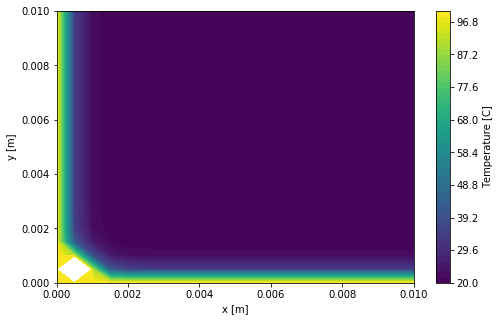

In [19]:
pyplot.figure(figsize=(8.0,5.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
contf = pyplot.contourf(x, y, T, levels = numpy.linspace(20.0, 100.0,num=51))
cbar = pyplot.colorbar(contf)
cbar.set_label('Temperature [C]')